## Sea Creatures Detection (PyTorch)

### Table of contents
- [Importing Libraries](#Importing-Libraries)
- [Data Augmentation](#Data-Augmentation)
- [Dataset Preparation](#Dataset-Preparation)
- [Data Exploration & Visualization](#Data-Exploration-&-Visualization)
- [Model Selection & Setup](#Model-Selection-&-Setup)
- [Training Loop](#Training-Loop)
- [Validation & Evaluation](#Validation-&-Evaluation)
- [Results Visualization](#Results-Visualization)
- [Testing on New Data](#Testing-on-New-Data)
- [Saving & Loading the Model](#Saving-&-Loading-the-Model)
- [COMPLETE WORKFLOW SUMMARY](#COMPLETE-WORKFLOW-SUMMARY)
- [KEY CONCEPTS EXPLAINED](#KEY-CONCEPTS-EXPLAINED)



<a id="Importing Libraries"></a>

### **Importing Libraries** :

    - torch: Main PyTorch library for deep learning
    - torch.nn (nn): Neural network modules (layers, loss functions)
    - torch.optim (optim): Optimizers (Adam, SGD, etc.)
    - DataLoader: Loads data in batches for training
    - datasets, transforms, models:
        - datasets: Pre-made datasets (ImageFolder for our custom data)
        - transforms: Image transformations (resize, crop, normalize)
        - models: Pretrained models (EfficientNet)
    - os, Path: File and path operations
    - numpy (np): Numerical operations
    - matplotlib.pyplot (plt): Plotting graphs
    - tqdm: Progress bars for loops
    - pandas (pd): Data manipulation (saving CSV files)
    - seaborn (sns): Statistical data visualization
    - sklearn.metrics: Evaluation metrics (accuracy, confusion matrix)
    - warnings: Suppress warning messages
    - Random seeds: Ensure reproducibility of results

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

### check for GPU available

In [2]:
print(torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

2.9.1+cu130
Using device: cuda


### **Centralized configuration**: All settings in one place

- Paths: Specifies where data is stored and where to save results
- **Model parameters**:
  - model_name: Which EfficientNet variant to use (b0-b7)
  - num_classes: 20 sea creature classes
  - input_size: Images resized to 224x224 pixels (standard for EfficientNet)

- **Training parameters**:

    batch_size: 32 images processed at once
    num_epochs: Train for 30 complete passes through data
    learning_rate: How fast the model learns (0.001)
    num_workers: 4 parallel processes for data loading

- Device: Automatically uses GPU if available, otherwise CPU (already used above)
- Save paths: Where to save trained model and results
- to_dict() method: Converts config to dictionary for saving

In [3]:
# Configuration - UPDATED VERSION
class Config:
    # Paths
    data_dir = r"D:\Data Sets\see creatures images"  # Change this to your data path
    train_dir = os.path.join(data_dir, "train")
    val_dir = os.path.join(data_dir, "valid")
    test_dir = os.path.join(data_dir, "test")
    
    # Model parameters
    model_name = "efficientnet_b0"  # You can use b0-b7
    num_classes = 20
    input_size = 224
    
    # Training parameters
    batch_size = 32
    num_epochs = 30
    learning_rate = 0.001
    num_workers = 4
    
    # Device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Save paths
    save_dir = "./sea_creatures_model_test1"
    best_model_path = os.path.join(save_dir, "best_model_sea_creatures.pth")
    
    @classmethod
    def to_dict(cls):
        """Convert Config class to dictionary for saving"""
        return {
            'data_dir': cls.data_dir,
            'train_dir': cls.train_dir,
            'val_dir': cls.val_dir,
            'test_dir': cls.test_dir,
            'model_name': cls.model_name,
            'num_classes': cls.num_classes,
            'input_size': cls.input_size,
            'batch_size': cls.batch_size,
            'num_epochs': cls.num_epochs,
            'learning_rate': cls.learning_rate,
            'num_workers': cls.num_workers,
            'device': str(cls.device),
            'save_dir': cls.save_dir,
            'best_model_path': cls.best_model_path
        }

# Create save directory
os.makedirs(Config.save_dir, exist_ok=True)

<a id="Data Augmentation"></a>

# Training Transforms (with Data Augmentation):

1. RandomResizedCrop(224): Randomly crops image to 224x224 (creates variations)
2. RandomHorizontalFlip(): Randomly flips image horizontally (mirror)
3. RandomRotation(20): Rotates image by random angle up to 20 degrees
4. ColorJitter(): Randomly changes brightness, contrast, saturation, hue
5. RandomAffine(): Randomly shifts image position
6. ToTensor(): Converts PIL image to PyTorch tensor (0-1 range)
7. Normalize(): Normalizes with ImageNet statistics (standard for pretrained models)

**Why augmentation?** Creates more training variations, prevents overfitting

# Validation/Test Transforms:

* Only resize + normalize (no random changes)
* Consistent evaluation

**ImageNet normalization values:** Pretrained models were trained with these values

---

1. Gets transforms from previous function
2. Creates datasets using ImageFolder:
   * Automatically reads folder structure
   * Each subfolder = one class
   * Applies appropriate transforms
3. Extracts class names from folder names
4. Returns: Train, validation, test datasets + class names

**Folder structure expected:**
- train/
- ├── dolphin/
- ├── shark/
- ├── octopus/
- └── ... (20 classes)
- valid/ (same structure)
- test/ (same structure)

---

# DataLoader = PyTorch utility that:

* Loads data in batches (32 images at a time)
* Handles shuffling and parallel loading

# Parameters:

1. shuffle=True for training: Randomizes order each epoch
2. shuffle=False for validation/test: Consistent evaluation
3. num_workers=4: 4 parallel processes load data
4. pin_memory=True: Faster data transfer to GPU

**Why batches?** More efficient than single images, enables gradient accumulation

In [4]:
#4
def get_data_transforms():
    """Define data transformations for training, validation, and testing"""
    
    # Training transformations with augmentation
    train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(Config.input_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225]),
    ])
    
    # Validation and test transformations (no augmentation)
    val_test_transforms = transforms.Compose([
        transforms.Resize((Config.input_size, Config.input_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225]),
    ])
    
    # Simple transform for inference (no normalization)
    inference_transforms = transforms.Compose([
        transforms.Resize((Config.input_size, Config.input_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225]),
    ])    
    return train_transforms, val_test_transforms,inference_transforms

def create_datasets():
    """Create training, validation, and test datasets"""
    
    # Updated to unpack 3 values instead of 2
    train_transforms, val_test_transforms, inference_transforms = get_data_transforms()
    
    # Create datasets
    train_dataset = datasets.ImageFolder(
        Config.train_dir, 
        transform=train_transforms
    )
    
    val_dataset = datasets.ImageFolder(
        Config.val_dir, 
        transform=val_test_transforms
    )
    
    test_dataset = datasets.ImageFolder(
        Config.test_dir, 
        transform=val_test_transforms
    )
    
    # Get class names
    class_names = train_dataset.classes
    
    return train_dataset, val_dataset, test_dataset, class_names

def create_dataloaders(train_dataset, val_dataset, test_dataset):
    """Create data loaders"""
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=Config.batch_size,
        shuffle=True,
        num_workers=Config.num_workers,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=Config.batch_size,
        shuffle=False,
        num_workers=Config.num_workers,
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=Config.batch_size,
        shuffle=False,
        num_workers=Config.num_workers,
        pin_memory=True
    )
    
    return train_loader, val_loader, test_loader

# Transfer Learning Strategy:

1. Load pretrained EfficientNet: Trained on ImageNet (1.2M images, 1000 classes)
2. Freeze early layers: Keep pretrained features, don't update weights
3. Replace classifier: Last layers customized for our 20 sea creatures

# New Classifier Structure:
- Input (1280 features from EfficientNet)
- ↓
- Dropout (30%) ← Prevents overfitting
- ↓
- Linear Layer (1280 → 512) ← Learns sea creature features
- ↓
- ReLU Activation ← Adds non-linearity
- ↓
- Dropout (20%) ← More regularization
- ↓
- Linear Layer (512 → 20) ← Final classification (20 sea creatures)

**Why freeze layers?** Early layers learn general features (edges, textures) that work for any image

---

1. **Optimizer (AdamW)**:
   * Updates model weights based on loss
   * AdamW: Improved Adam with better weight decay
   * Only trains classifier: Frozen layers don't get updated
   * Weight decay (1e-4): Regularization to prevent overfitting

2. **Learning Rate Scheduler (CosineAnnealingLR)**:
   * Gradually reduces learning rate
   * Cosine schedule: Smooth decrease like cosine wave
   * **Why?** Helps converge to better minimum

3. **Loss Function (CrossEntropyLoss)**:
   * Measures prediction error
   * For classification with multiple classes
   * Penalizes wrong predictions

In [5]:
#4 model setup
def create_model():
    """Create EfficientNet model with pretrained weights"""
    
    # Load pretrained EfficientNet
    if Config.model_name == "efficientnet_b0":
        model = models.efficientnet_b0(pretrained=True)
    elif Config.model_name == "efficientnet_b1":
        model = models.efficientnet_b1(pretrained=True)
    elif Config.model_name == "efficientnet_b2":
        model = models.efficientnet_b2(pretrained=True)
    elif Config.model_name == "efficientnet_b3":
        model = models.efficientnet_b3(pretrained=True)
    elif Config.model_name == "efficientnet_b4":
        model = models.efficientnet_b4(pretrained=True)
    elif Config.model_name == "efficientnet_b5":
        model = models.efficientnet_b5(pretrained=True)
    elif Config.model_name == "efficientnet_b6":
        model = models.efficientnet_b6(pretrained=True)
    elif Config.model_name == "efficientnet_b7":
        model = models.efficientnet_b7(pretrained=True)
    else:
        raise ValueError(f"Model {Config.model_name} not supported")
    
    # Freeze early layers for transfer learning
    for param in model.parameters():
        param.requires_grad = False
    
    # Modify the classifier for our 20 classes
    num_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(num_features, 512),
        nn.ReLU(),
        nn.Dropout(p=0.2),
        nn.Linear(512, Config.num_classes)
    )
    
    # Move model to device
    model = model.to(Config.device)
    
    return model

def setup_optimizer_scheduler(model):
    """Setup optimizer and learning rate scheduler"""
    
    # Only train the classifier parameters
    optimizer = optim.AdamW(
        model.classifier.parameters(),
        lr=Config.learning_rate,
        weight_decay=1e-4
    )
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer, 
        T_max=Config.num_epochs
    )
    
    # Loss function
    criterion = nn.CrossEntropyLoss()
    
    return optimizer, scheduler, criterion

<a id="training-info"></a>

# For each batch of 32 images:

1. model.train(): Sets model to training mode (enables dropout)
2. Move to device: Transfer images to GPU/CPU
3. optimizer.zero_grad(): Clear previous gradients
4. Forward pass: Model makes predictions
5. Calculate loss: Compare predictions with true labels
6. loss.backward(): Calculate gradients (how to change weights)
7. optimizer.step(): Update weights using gradients
8. Calculate accuracy: Track performance
---
# Key concepts:

* Epoch: One complete pass through all training data
* Batch: Subset of data (32 images)
* Iteration: Processing one batch
* Gradient: Direction to adjust weights to reduce loss
---
# Different from training:

1. model.eval(): Disables dropout, batchnorm uses running statistics
2. torch.no_grad(): No gradient calculation (faster, less memory)
3. Only forward pass: No weight updates
4. Purpose: Check model performance on unseen data

**Why validate?** Monitor for overfitting (good on train, bad on validation)

In [6]:
# 5 training 
def train_epoch(model, train_loader, criterion, optimizer, epoch):
    """Train for one epoch"""
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{Config.num_epochs} [Train]')
    
    for batch_idx, (inputs, targets) in enumerate(pbar):
        inputs, targets = inputs.to(Config.device), targets.to(Config.device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Statistics
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        # Update progress bar
        pbar.set_postfix({
            'Loss': f'{train_loss/(batch_idx+1):.4f}',
            'Acc': f'{100.*correct/total:.2f}%'
        })
    
    return train_loss/len(train_loader), 100.*correct/total

def validate(model, val_loader, criterion):
    """Validate the model"""
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(val_loader, desc='[Validation]')
        for batch_idx, (inputs, targets) in enumerate(pbar):
            inputs, targets = inputs.to(Config.device), targets.to(Config.device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Statistics
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            pbar.set_postfix({
                'Loss': f'{val_loss/(batch_idx+1):.4f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })
    
    return val_loss/len(val_loader), 100.*correct/total


# Training process:

1. Loop for 30 epochs
2. Each epoch: Train → Validate → Adjust learning rate
3. Save best model: Only when validation accuracy improves
4. Checkpoint includes: Weights, optimizer state, class names, config
---
# Model saving details:

* state_dict(): Model weights only (not entire model)
* **Why save optimizer state?** Can resume training
* Class names: For inference later

In [7]:
#6 main training loop
def train_model():
    """Main training function"""
    
    print(f"Using device: {Config.device}")
    print(f"Number of classes: {Config.num_classes}")
    
    # Create datasets and dataloaders
    print("Loading datasets...")
    train_dataset, val_dataset, test_dataset, class_names = create_datasets()
    
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}")
    print(f"Class names: {class_names}")
    
    train_loader, val_loader, test_loader = create_dataloaders(
        train_dataset, val_dataset, test_dataset
    )
    
    # Create model
    print(f"\nCreating {Config.model_name} model...")
    model = create_model()
    
    # Setup optimizer and criterion
    optimizer, scheduler, criterion = setup_optimizer_scheduler(model)
    
    # Training history
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'learning_rate': []
    }
    
    best_val_acc = 0.0
    
    print("\nStarting training...")
    for epoch in range(Config.num_epochs):
        print(f"\n{'='*50}")
        print(f"Epoch {epoch+1}/{Config.num_epochs}")
        print(f"{'='*50}")
        
        # Train
        train_loss, train_acc = train_epoch(
            model, train_loader, criterion, optimizer, epoch
        )
        
        # Validate
        val_loss, val_acc = validate(model, val_loader, criterion)
        
        # Update learning rate
        scheduler.step()
        
        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['learning_rate'].append(optimizer.param_groups[0]['lr'])
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'class_names': class_names,
                'config': Config.to_dict()  # CHANGED THIS LINE
            }, Config.best_model_path)
            print(f"\n✓ Best model saved with validation accuracy: {val_acc:.2f}%")
        
        print(f"\nEpoch Summary:")
        print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        print(f"  Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
    
    print(f"\n{'='*50}")
    print(f"Training completed!")
    print(f"Best validation accuracy: {best_val_acc:.2f}%")
    
    return model, history, class_names

---
# Final evaluation on test set:

1. Collect all predictions: Store predictions and true labels
2. Classification report: Precision, recall, F1-score for each class
3. Confusion matrix: Shows which classes get confused
---
# Metrics explained:

* Precision: Of predicted class X, how many were actually X?
* Recall: Of actual class X, how many were predicted as X?
* F1-score: Harmonic mean of precision and recall
* Accuracy: Overall correct predictions

---

# Three plots:

1. Loss over epochs: Should decrease for both train and validation
2. Accuracy over epochs: Should increase
3. Learning rate schedule: Shows how LR changes
---
# What to look for:

* Good: Train/val curves close together
* Overfitting: Train accuracy >> Val accuracy
* Underfitting: Both accuracies low
* Learning rate too high: Loss NaN or spikes

---
# Single image prediction:

1. Load image: Open and convert to RGB
2. Apply transforms: Same as validation
3. unsqueeze(0): Add batch dimension (1 image → batch of 1)
4. Softmax: Convert outputs to probabilities (0-1)
5. Top-5 predictions: Show 5 most likely classes
---
# Key steps for inference:

* Always use same transforms as validation
* Set model to eval mode
* Use torch.no_grad() for efficiency
* Softmax gives interpretable probabilities

In [8]:
#7 Evaluation  
def evaluate_model(model, test_loader, class_names):
    """Evaluate model on test set"""
    model.eval()
    all_preds = []
    all_targets = []
    
    print("\nEvaluating on test set...")
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc='Testing'):
            inputs = inputs.to(Config.device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.numpy())
    
    # Classification report
    print("\n" + "="*50)
    print("Classification Report:")
    print("="*50)
    print(classification_report(
        all_targets, 
        all_preds, 
        target_names=class_names,
        digits=4
    ))
    
    # Confusion matrix
    cm = confusion_matrix(all_targets, all_preds)
    return all_preds, all_targets, cm

def plot_training_history(history):
    """Plot training history"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Plot loss
    axes[0].plot(history['train_loss'], label='Train Loss')
    axes[0].plot(history['val_loss'], label='Val Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True)
    
    # Plot accuracy
    axes[1].plot(history['train_acc'], label='Train Acc')
    axes[1].plot(history['val_acc'], label='Val Acc')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].legend()
    axes[1].grid(True)
    
    # Plot learning rate
    axes[2].plot(history['learning_rate'])
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Learning Rate')
    axes[2].set_title('Learning Rate Schedule')
    axes[2].grid(True)
    
    plt.tight_layout()
    plt.savefig(os.path.join(Config.save_dir, 'training_history.png'))
    plt.show()

def plot_confusion_matrix(cm, class_names, save_path=None):
    """Plot confusion matrix"""
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

def predict_single_image(model, image_path, class_names, transform):
    """Predict a single image"""
    from PIL import Image
    
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(Config.device)
    
    # Predict
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        conf, preds = torch.max(probabilities, 1)
    
    # Get top 5 predictions
    top5_conf, top5_idx = torch.topk(probabilities, 5)
    
    print(f"\nPrediction for: {image_path}")
    print(f"Top prediction: {class_names[preds.item()]} ({conf.item():.2%})")
    print("\nTop 5 predictions:")
    for i in range(5):
        print(f"  {i+1}. {class_names[top5_idx[0][i].item()]}: {top5_conf[0][i].item():.2%}")
    
    return class_names[preds.item()], conf.item()

---
# Workflow:

1. Train: 32 epochs, save best model
2. Visualize: Training curves
3. Load best: Use best validation model
4. Test: Final evaluation on unseen test data
5. Analyze: Confusion matrix, classification report
6. Save: Model, class names, results

Using device: cuda
Number of classes: 20
Loading datasets...
Training samples: 38415
Validation samples: 950
Test samples: 380
Class names: ['Clam', 'Crab', 'Dolphin', 'Eel', 'Jelly Fish', 'Lobster', 'Octopus', 'Otter', 'Puffer', 'Sea Horse', 'Sea Ray', 'Sea Turtle', 'Sea Urchin', 'Seal', 'Shark', 'Shrimp', 'Squid', 'Starfish', 'Whale']

Creating efficientnet_b0 model...

Starting training...

Epoch 1/30


[Validation]: 100%|██████████| 30/30 [00:19<00:00,  1.56it/s, Loss=0.8223, Acc=73.79%]



✓ Best model saved with validation accuracy: 73.79%

Epoch Summary:
  Train Loss: 1.3563, Train Acc: 57.79%
  Val Loss: 0.8223, Val Acc: 73.79%
  Learning Rate: 0.000997

Epoch 2/30


[Validation]: 100%|██████████| 30/30 [00:20<00:00,  1.47it/s, Loss=0.7472, Acc=76.53%]



✓ Best model saved with validation accuracy: 76.53%

Epoch Summary:
  Train Loss: 1.1879, Train Acc: 62.52%
  Val Loss: 0.7472, Val Acc: 76.53%
  Learning Rate: 0.000989

Epoch 3/30


[Validation]: 100%|██████████| 30/30 [00:21<00:00,  1.37it/s, Loss=0.7254, Acc=77.79%]



✓ Best model saved with validation accuracy: 77.79%

Epoch Summary:
  Train Loss: 1.1311, Train Acc: 64.21%
  Val Loss: 0.7254, Val Acc: 77.79%
  Learning Rate: 0.000976

Epoch 4/30


[Validation]: 100%|██████████| 30/30 [00:20<00:00,  1.47it/s, Loss=0.6973, Acc=78.95%]



✓ Best model saved with validation accuracy: 78.95%

Epoch Summary:
  Train Loss: 1.1196, Train Acc: 65.08%
  Val Loss: 0.6973, Val Acc: 78.95%
  Learning Rate: 0.000957

Epoch 5/30


[Validation]: 100%|██████████| 30/30 [00:20<00:00,  1.49it/s, Loss=0.7159, Acc=76.95%]



Epoch Summary:
  Train Loss: 1.0981, Train Acc: 65.53%
  Val Loss: 0.7159, Val Acc: 76.95%
  Learning Rate: 0.000933

Epoch 6/30


[Validation]: 100%|██████████| 30/30 [00:19<00:00,  1.56it/s, Loss=0.6459, Acc=79.37%]



✓ Best model saved with validation accuracy: 79.37%

Epoch Summary:
  Train Loss: 1.0800, Train Acc: 65.95%
  Val Loss: 0.6459, Val Acc: 79.37%
  Learning Rate: 0.000905

Epoch 7/30


[Validation]: 100%|██████████| 30/30 [00:20<00:00,  1.49it/s, Loss=0.6774, Acc=79.47%]



✓ Best model saved with validation accuracy: 79.47%

Epoch Summary:
  Train Loss: 1.0600, Train Acc: 66.82%
  Val Loss: 0.6774, Val Acc: 79.47%
  Learning Rate: 0.000872

Epoch 8/30


[Validation]: 100%|██████████| 30/30 [00:21<00:00,  1.39it/s, Loss=0.6696, Acc=79.68%]



✓ Best model saved with validation accuracy: 79.68%

Epoch Summary:
  Train Loss: 1.0565, Train Acc: 66.70%
  Val Loss: 0.6696, Val Acc: 79.68%
  Learning Rate: 0.000835

Epoch 9/30


[Validation]: 100%|██████████| 30/30 [00:20<00:00,  1.48it/s, Loss=0.6613, Acc=79.47%]



Epoch Summary:
  Train Loss: 1.0437, Train Acc: 67.31%
  Val Loss: 0.6613, Val Acc: 79.47%
  Learning Rate: 0.000794

Epoch 10/30


[Validation]: 100%|██████████| 30/30 [00:22<00:00,  1.35it/s, Loss=0.6288, Acc=80.21%]



✓ Best model saved with validation accuracy: 80.21%

Epoch Summary:
  Train Loss: 1.0299, Train Acc: 68.02%
  Val Loss: 0.6288, Val Acc: 80.21%
  Learning Rate: 0.000750

Epoch 11/30


[Validation]: 100%|██████████| 30/30 [00:20<00:00,  1.49it/s, Loss=0.6259, Acc=80.53%]



✓ Best model saved with validation accuracy: 80.53%

Epoch Summary:
  Train Loss: 1.0174, Train Acc: 67.74%
  Val Loss: 0.6259, Val Acc: 80.53%
  Learning Rate: 0.000703

Epoch 12/30


[Validation]: 100%|██████████| 30/30 [00:20<00:00,  1.44it/s, Loss=0.6097, Acc=81.58%]



✓ Best model saved with validation accuracy: 81.58%

Epoch Summary:
  Train Loss: 1.0102, Train Acc: 68.49%
  Val Loss: 0.6097, Val Acc: 81.58%
  Learning Rate: 0.000655

Epoch 13/30


[Validation]: 100%|██████████| 30/30 [00:22<00:00,  1.34it/s, Loss=0.6038, Acc=82.11%]



✓ Best model saved with validation accuracy: 82.11%

Epoch Summary:
  Train Loss: 0.9964, Train Acc: 68.70%
  Val Loss: 0.6038, Val Acc: 82.11%
  Learning Rate: 0.000604

Epoch 14/30


[Validation]: 100%|██████████| 30/30 [00:23<00:00,  1.26it/s, Loss=0.6152, Acc=81.58%]



Epoch Summary:
  Train Loss: 0.9890, Train Acc: 69.21%
  Val Loss: 0.6152, Val Acc: 81.58%
  Learning Rate: 0.000552

Epoch 15/30


[Validation]: 100%|██████████| 30/30 [00:23<00:00,  1.26it/s, Loss=0.6021, Acc=82.11%]



Epoch Summary:
  Train Loss: 0.9822, Train Acc: 69.11%
  Val Loss: 0.6021, Val Acc: 82.11%
  Learning Rate: 0.000500

Epoch 16/30


[Validation]: 100%|██████████| 30/30 [00:24<00:00,  1.24it/s, Loss=0.6159, Acc=80.11%]



Epoch Summary:
  Train Loss: 0.9707, Train Acc: 69.51%
  Val Loss: 0.6159, Val Acc: 80.11%
  Learning Rate: 0.000448

Epoch 17/30


[Validation]: 100%|██████████| 30/30 [00:24<00:00,  1.22it/s, Loss=0.5862, Acc=82.53%]



✓ Best model saved with validation accuracy: 82.53%

Epoch Summary:
  Train Loss: 0.9536, Train Acc: 70.26%
  Val Loss: 0.5862, Val Acc: 82.53%
  Learning Rate: 0.000396

Epoch 18/30


[Validation]: 100%|██████████| 30/30 [00:27<00:00,  1.10it/s, Loss=0.5567, Acc=82.53%]



Epoch Summary:
  Train Loss: 0.9438, Train Acc: 70.19%
  Val Loss: 0.5567, Val Acc: 82.53%
  Learning Rate: 0.000345

Epoch 19/30


[Validation]: 100%|██████████| 30/30 [00:31<00:00,  1.06s/it, Loss=0.5794, Acc=82.74%]



✓ Best model saved with validation accuracy: 82.74%

Epoch Summary:
  Train Loss: 0.9351, Train Acc: 70.74%
  Val Loss: 0.5794, Val Acc: 82.74%
  Learning Rate: 0.000297

Epoch 20/30


[Validation]: 100%|██████████| 30/30 [00:32<00:00,  1.09s/it, Loss=0.5781, Acc=82.11%]



Epoch Summary:
  Train Loss: 0.9272, Train Acc: 70.96%
  Val Loss: 0.5781, Val Acc: 82.11%
  Learning Rate: 0.000250

Epoch 21/30


[Validation]: 100%|██████████| 30/30 [00:24<00:00,  1.24it/s, Loss=0.5425, Acc=84.21%]



✓ Best model saved with validation accuracy: 84.21%

Epoch Summary:
  Train Loss: 0.9234, Train Acc: 70.89%
  Val Loss: 0.5425, Val Acc: 84.21%
  Learning Rate: 0.000206

Epoch 22/30


[Validation]: 100%|██████████| 30/30 [00:18<00:00,  1.64it/s, Loss=0.5834, Acc=82.00%]



Epoch Summary:
  Train Loss: 0.9189, Train Acc: 71.20%
  Val Loss: 0.5834, Val Acc: 82.00%
  Learning Rate: 0.000165

Epoch 23/30


[Validation]: 100%|██████████| 30/30 [00:21<00:00,  1.40it/s, Loss=0.5503, Acc=82.95%]



Epoch Summary:
  Train Loss: 0.9111, Train Acc: 71.34%
  Val Loss: 0.5503, Val Acc: 82.95%
  Learning Rate: 0.000128

Epoch 24/30


[Validation]: 100%|██████████| 30/30 [00:22<00:00,  1.34it/s, Loss=0.5404, Acc=84.00%]



Epoch Summary:
  Train Loss: 0.9061, Train Acc: 71.60%
  Val Loss: 0.5404, Val Acc: 84.00%
  Learning Rate: 0.000095

Epoch 25/30


[Validation]: 100%|██████████| 30/30 [00:23<00:00,  1.26it/s, Loss=0.5467, Acc=84.21%]



Epoch Summary:
  Train Loss: 0.9010, Train Acc: 71.72%
  Val Loss: 0.5467, Val Acc: 84.21%
  Learning Rate: 0.000067

Epoch 26/30


[Validation]: 100%|██████████| 30/30 [00:22<00:00,  1.34it/s, Loss=0.5377, Acc=84.00%]



Epoch Summary:
  Train Loss: 0.8950, Train Acc: 71.72%
  Val Loss: 0.5377, Val Acc: 84.00%
  Learning Rate: 0.000043

Epoch 27/30


[Validation]: 100%|██████████| 30/30 [00:22<00:00,  1.30it/s, Loss=0.5486, Acc=84.42%]



✓ Best model saved with validation accuracy: 84.42%

Epoch Summary:
  Train Loss: 0.8838, Train Acc: 71.93%
  Val Loss: 0.5486, Val Acc: 84.42%
  Learning Rate: 0.000024

Epoch 28/30


[Validation]: 100%|██████████| 30/30 [00:24<00:00,  1.23it/s, Loss=0.5416, Acc=84.11%]



Epoch Summary:
  Train Loss: 0.8916, Train Acc: 72.06%
  Val Loss: 0.5416, Val Acc: 84.11%
  Learning Rate: 0.000011

Epoch 29/30


[Validation]: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.5537, Acc=84.00%]



Epoch Summary:
  Train Loss: 0.8914, Train Acc: 72.06%
  Val Loss: 0.5537, Val Acc: 84.00%
  Learning Rate: 0.000003

Epoch 30/30


[Validation]: 100%|██████████| 30/30 [00:20<00:00,  1.49it/s, Loss=0.5371, Acc=84.32%]



Epoch Summary:
  Train Loss: 0.8886, Train Acc: 72.30%
  Val Loss: 0.5371, Val Acc: 84.32%
  Learning Rate: 0.000000

Training completed!
Best validation accuracy: 84.42%


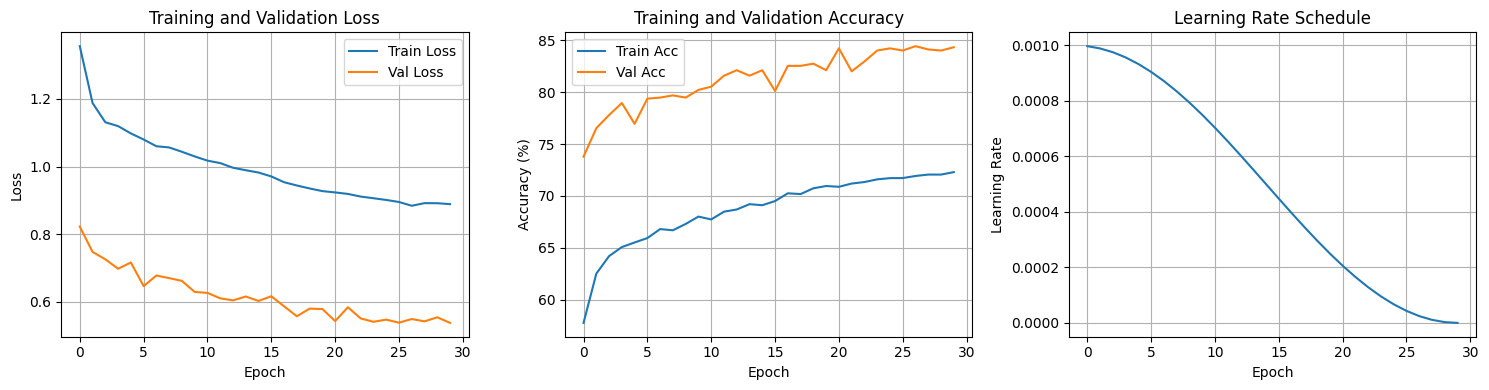


Evaluating on test set...


Testing: 100%|██████████| 12/12 [00:07<00:00,  1.56it/s]



Classification Report:
              precision    recall  f1-score   support

        Clam     0.6364    0.7000    0.6667        20
        Crab     0.7826    0.9000    0.8372        20
     Dolphin     0.8750    0.7000    0.7778        20
         Eel     0.6842    0.6500    0.6667        20
  Jelly Fish     0.9000    0.9000    0.9000        20
     Lobster     0.6400    0.8000    0.7111        20
     Octopus     0.8235    0.7000    0.7568        20
       Otter     0.8182    0.9000    0.8571        20
      Puffer     0.7222    0.6500    0.6842        20
   Sea Horse     0.8500    0.8500    0.8500        20
     Sea Ray     0.7308    0.9500    0.8261        20
  Sea Turtle     0.7895    0.7500    0.7692        20
  Sea Urchin     0.9474    0.9000    0.9231        20
        Seal     0.8947    0.8500    0.8718        20
       Shark     0.6667    0.6000    0.6316        20
      Shrimp     0.8421    0.8000    0.8205        20
       Squid     0.8000    0.8000    0.8000        20
   

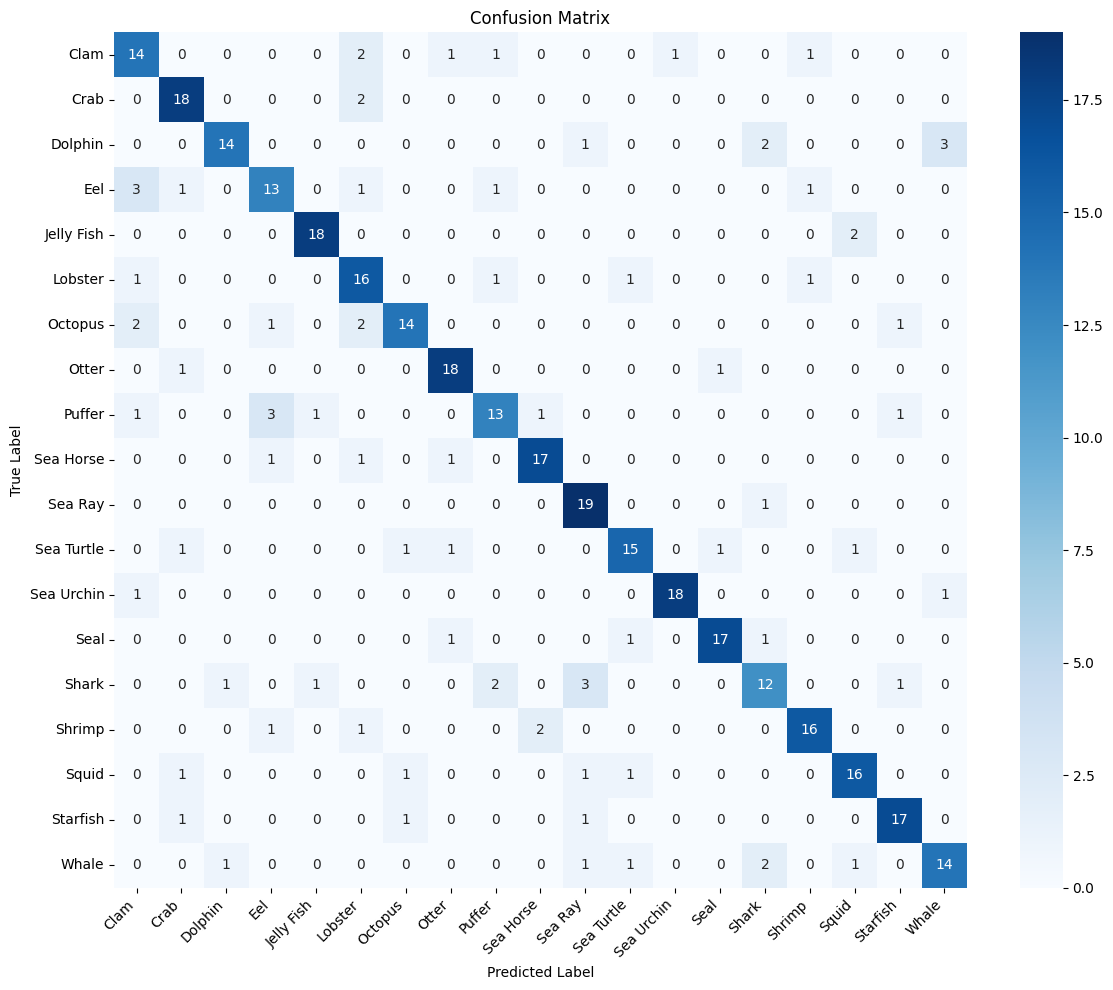


Model and results saved in: ./sea_creatures_model_test1


In [9]:
# 8 main execution
def main():
    """Main execution function"""
    config = Config()
    # Train the model
    model, history, class_names = train_model()
    
    # Plot training history
    plot_training_history(history)
    
    # Load best model for evaluation
    checkpoint = torch.load(Config.best_model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Create test dataloader
    _, test_transforms, _ = get_data_transforms()  # Updated to get correct transforms    
    test_dataset = datasets.ImageFolder(Config.test_dir, transform=test_transforms)
    test_loader = DataLoader(test_dataset, batch_size=Config.batch_size, shuffle=False)
    
    # Evaluate on test set
    all_preds, all_targets, cm = evaluate_model(model, test_loader, class_names)
    
    # Plot confusion matrix
    plot_confusion_matrix(cm, class_names, 
                         os.path.join(Config.save_dir, 'confusion_matrix.png'))
    
    # Save class names
    with open(os.path.join(Config.save_dir, 'class_names.txt'), 'w') as f:
        for name in class_names:
            f.write(f"{name}\n")
    
    print(f"\nModel and results saved in: {Config.save_dir}")
    
    # Example: Predict a single image
    # Uncomment and modify the path to test a specific image
    # test_image_path = "path/to/your/test/image.jpg"
    # predict_single_image(model, test_image_path, class_names, test_transforms)

if __name__ == "__main__":
    main()

---

<a id="COMPLETE WORKFLOW SUMMARY"></a>

# COMPLETE WORKFLOW SUMMARY:

1. Setup: Import libraries, set random seeds
2. Configuration: Define all parameters in one place
3. Data Preparation:
   * Create transforms (augmentation for train)
   * Load images from folders
   * Create DataLoaders for batching
4. Model Creation:
   * Load pretrained EfficientNet
   * Freeze early layers
   * Replace classifier for 20 classes
5. Training:
   * 30 epochs of train → validate
   * Save best model based on validation accuracy
   * Adjust learning rate each epoch
6. Evaluation:
   * Test on unseen data
   * Generate classification metrics
   * Create confusion matrix
7. Visualization:
   * Plot training history
   * Show confusion matrix
8. Saving:
   * Save trained model
   * Save class names
   * Save training history
9. Inference: Predict new images



---

<a id="KEY CONCEPTS EXPLAINED"></a>

# KEY CONCEPTS EXPLAINED:

**Transfer Learning**  
Using a model pretrained on large dataset (ImageNet), adapting it to our specific task (sea creatures)

**Data Augmentation**  
Creating variations of training images to prevent overfitting and improve generalization

**Batch Processing**  
Processing multiple images together for efficiency and better gradient estimates

**Epoch vs Batch vs Iteration**

* Batch: Group of images (30)
* Iteration: Processing one batch
* Epoch: All batches processed once

**Model Modes**

* .train(): Enables dropout, batch norm uses batch statistics
* .eval(): Disables dropout, batch norm uses running statistics

**Loss Function**  
Measures how wrong predictions are, guides weight updates

**Optimizer**  
Algorithm that updates weights based on loss gradients

**Learning Rate Scheduler**  
Adjusts learning rate during training for better convergence

**Overfitting**  
Model memorizes training data but fails on new data  
Solutions: Dropout, data augmentation, weight decay

**Underfitting**  
Model too simple to learn patterns  
Solutions: More layers, more training, reduce regularization

---
## **back to above**: [Importing Libraries ](#Importing-Libraries)
---